# From Asset Management to Asset-Liability Management

Durante as crises, quando o valor das ações caem, uma medida tomada pelo governo para melhorar o preço das ações pode ser a diminuição na taxa de juros. Mas, com isso, as empresas vão se endividar mais, pois pegam dinheiro empresatado a taxas menores

Cenário pessimo: Assets going down, Liabilities going up

$$  FundingRatio = \frac{Asset}{Liability} $$

Funding Ration vai dar a porção do passivo que pode ser paga com os ativos

$$  Surplus = Asset - Liability  $$

## Present Value of Liabilities and Funding Ratio

Ao invés de buscar apenas aumentar valor dos ativos, podemos ter como objetivo de um investimento garantir que teremos dinheiro para fazer as coisas que a gente quer no futuro.


Present value of liabilities:

$$  PV(L) = \sum_{i=1}^k B(t_i)L_i   $$

sendo que $B(t_i)$ é o preço de um título que paga 1 dólar no período $t_i$ e $L_i$ são as liabilities na data i

$$ B(t)(1+r)^t = 1 $$

ou

$$ B(t) = \frac {1}{(1+r)^t} $$

In [19]:
import pandas as pd
import numpy as np
import edhec_risk_kit as erk
%load_ext autoreload
%autoreload 2

interactive(children=(IntSlider(value=50, description='n_scenarios', max=1000, min=1, step=5), FloatSlider(val…

In [3]:
from IPython import display

In [2]:
def discount(t,r):
    """
    Computa taxa de desconto numa data t, dado uma taxa de
    juros r que não muda ao longo do tempo
    """
    return (1+r)**(-t)

In [4]:
discount(10,.03) # invista isso, e tenha 1 dólar daqui a 10 anos

0.7440939148967249

In [22]:
def pv(l,r):
    """
    Calcula valor presente de uma sequencia de liabilities
    l é indexado pelo tempo (data) e os valores são
    o tamanho desse passivo
    retorna o valor presente
    """
    dates = l.index
    discounts = discount(dates, r)
    return (l*discounts).sum()

In [13]:
liabilities = pd.Series(data=[1, 1.5,2, 2.5],
                        index=[3,3.5,4,4.5])

In [15]:
liabilities # daqui 3 anos devo pagar 1.0M dolares,
            # daqui 3,5 devo pagar 1.5M

3.0    1.0
3.5    1.5
4.0    2.0
4.5    2.5
dtype: float64

In [23]:
pv(liabilities, 0.03)

6.233320315080045

In [24]:
liabilities.sum()

7.0

In [25]:
def funding_ratio(assets, liabilities, r):
    """
    Computa o funding ratio
    """
    return assets/pv(liabilities, r)

In [27]:
funding_ratio(5, liabilities, 0.03) # se tenho 5M de ativos
                                    # hoje, eles não são
                                    # suficientes para cobrir
                                    # meus passivos (PV)

0.8021407126958777

In [29]:
funding_ratio(5, liabilities, 0.02)
# uma diminuição no retorno piora a situação

0.7720304366941648

Para melhorar funding ratio, tem que aumentar taxa r, ou seja, aumentar o retorno dos ativos, ou limitar crescimento do PV das liabilities

## Liability Hedging Portfolios (Goal-hedging portfolios) (LHP, GHP)

São portfolios com payoffs que estão de acordo (valor e data) com os pagamentos dos passivos(ou goals - para investidores individuais

Vai usar derivativos para fazer o hedge

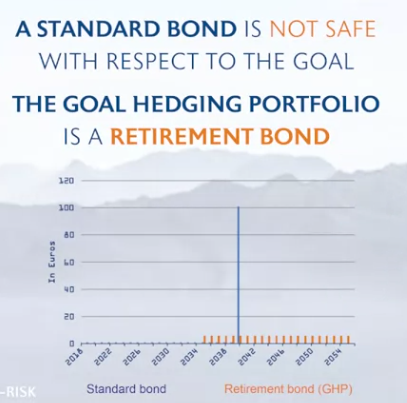

In [4]:
display.Image('pics/Captura de tela de 2022-10-17 17-04-38.png')

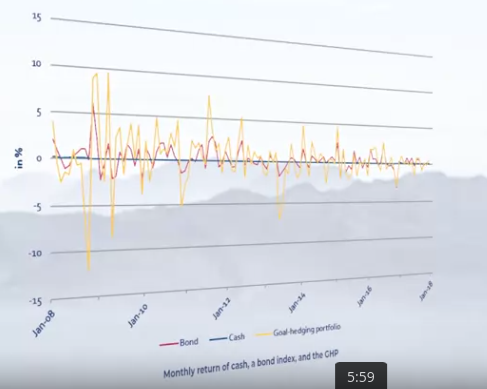

In [5]:
display.Image('pics/Captura de tela de 2022-10-17 17-10-41.png')

Olhando para essa imagem, vemos que a bond (curto prazo - vermelho) tem menos volatilidade que o GHP (bond de longo prazo - amarelo). O dinheiro parece ser investimento seguro

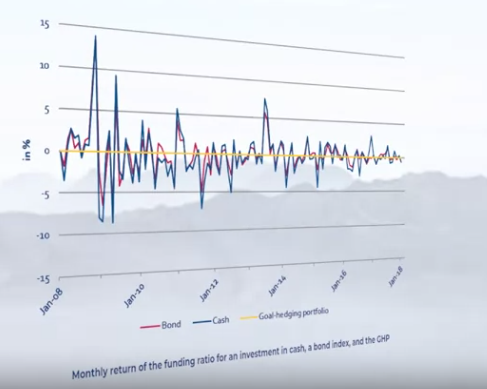

In [6]:
display.Image('pics/Captura de tela de 2022-10-17 17-10-50.png')

Mas quando pensamos em termos de liabilities (funding ratio), GHP tem menos risco.



O problema é que nem sempre é tão facil fazer o cash-flor matching do portifolio (alinhar recebimentos às expectativas).

-> Factor Exposure Matching (Duration matching)

## CIR Model to simulate changes in Interest Rates and Liability Hedging

Cox Ingersoll Ross Model é usado quando há mudança nas taxas de juros e é uma extensão do modelo de Vasicek que tira taxas de juros negativas

$$  dr_t = a(b-r_t)dt + \sigma \sqrt r_t  dW_t  $$ 

A equação diferencial diz: 
- Uma pequena mudança na taxa de juros $dr_t$ está associada a velocidade ($a$) com que os valores convergem para a média ($b$(média de longo prazo) $- r_t$ (taxa atual)) e a variação de um número aleatório ($dW_t$) $*$ pela volatilitade ($\sigma$) e pela raiz de r ($\sqrt r_t$) que diminui a chance de chegar numa taxa de juros negativa


### Short rate (r_t) vs Annualized

Short rate é como a taxa DI (empréstimos por pouquíssimo tempo). É como se dividisse os pagamentos anuais em várias fraçoes de tempo. (acho que isso é a taxa da capitalização)

Se dividimos em N vezes no ano:

$$ r_{cap} = (1 + \frac{r}{N}) ^ N $$ 

In [7]:
# por exemplo, se quisesse saber a taxa de 100% ao ano, 2 vezes:
r = (1+1/2)**2
r

2.25

In [8]:
# se n aumentar muito:

(1+1/100000)**100000


2.7182682371922975

Esse é perto do número de euler

Quando N fica muito grande temos:

$$ 1 + r_{annual} = e^{r_{inst}}$$

ou

$$ r_{annual} = e^{r_{inst}} - 1$$

ou

$$  r_{inst} = ln(1+r_{annual})  $$

In [10]:
def inst_to_ann(r):
    """
    Converte taxa instantanea para anualizada
    """
    return np.expm1(r)

def ann_to_inst(r):
    """
    Converte taxa anualizada para instantanea
    """
    return np.log1p(r)

$$  dr_t = a(b-r_t)dt + \sigma \sqrt r_t  dW_t  $$ 

In [20]:
def cir(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05,
       steps_per_year=12, r_0=None):
    """
    Implementando the CIR model for interest rates (dr_t)
    """
    if r_0 is None: r_0 = b 
    
    # temos que transformar em taxa instantanea (mesmo que pra 
    # taxas pequenas não faça tanta diferença)
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    
    num_steps = int(n_years*steps_per_year) + 1 # +1 ajusta para 
                                                # inlcuir data 0
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps,
                                                        n_scenarios))
    # porque desvio padrão do número aleatório é raiz de d_t?
    rates = np.empty_like(shock)
    rates[0] = r_0
    
    for step in range(1, num_steps): # pq primeiro (rates[0]) já foi computado
        r_t = rates[step-1] # taxa inicial
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t) # garante que taxa não será neg
    
    return pd.DataFrame(data=inst_to_ann(rates), 
                        index=range(num_steps))
        

<AxesSubplot:>

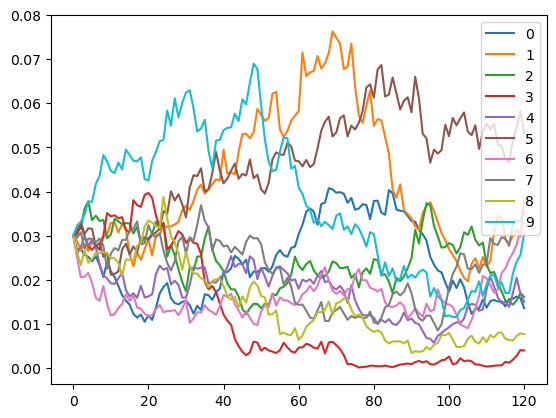

In [21]:
cir(n_scenarios=10).plot()